##### Setup #####

In [4]:
#Imports
#!pip install gensim
import re
import csv
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt 
import itertools
import numpy as np
import sklearn
import sklearn.linear_model
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from collections import Counter
import gensim.downloader as api

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn import metrics


Load CSV file, leaving only the collumns we might be interested in.

In [21]:
''' reads data from a CSV file, filters it by type, removes duplicates and unnecessary columns, and writes the filtered data to a new CSV file.'''
##### -- Functions -- #####
def getParts():
    dropList = ['domain', 'url', 'scraped_at', 'updated_at', 'title', 'authors', 'keywords', 'meta_keywords', 'tags', 'summary' ] # 'source'

    df = pd.read_csv('csvFile.csv', nrows=100000)
    
    # Filter fake
    df_fake = df.loc[df['type'] == 'fake']
    df_conspiracy = df.loc[df['type'] == 'conspiracy']

    #filter reliable
    df_reliable = df.loc[df['type'] == 'reliable']
    df_political = df.loc[df['type'] == 'political']

    #Concat
    df_reliable = pd.concat([df_political, df_reliable], ignore_index=True)
    df_fake = pd.concat([df_conspiracy, df_fake], ignore_index=True)
    df_filtered = pd.concat([df_fake, df_reliable], ignore_index=True)

    #Dublicate list
    dub = ("duplicates: ", df_filtered.duplicated(subset=['content']).sum())
    total = df_filtered.shape[0]
    percentOfDublicates = round(dub / total * 100)
    print("Duplicates: " + str(percentOfDublicates) + "%")

    # Write DataFrame to CSV file
    df_filtered = df_filtered.drop(dropList, axis=1)
    df_filtered.drop_duplicates(subset=['content'], inplace=True)
    df_filtered.to_csv('readyData.csv', index=False)

    ##### -- Prints -- #####
    print("Fake / reliable")
    print(df_fake.index)
    print(df_reliable.index)
    print("")
    print("loaded index")
    print(df.index)
    print("")
    print("filtered")
    print(df_filtered)
    print("")
    print("Creates a csv file called: readyData.csv")
#getParts()

duplicates:  10211
Fake / reliable
RangeIndex(start=0, stop=52645, step=1)
RangeIndex(start=0, stop=27660, step=1)

loaded index
RangeIndex(start=0, stop=100000, step=1)

filtered
       Unnamed: 0      id        type  \
0              10      17  conspiracy   
1              11      18  conspiracy   
2              12      19  conspiracy   
3              13      20  conspiracy   
4              56      68  conspiracy   
...           ...     ...         ...   
80298        7790   96593    reliable   
80300        1189  101029    reliable   
80301        4169  105092    reliable   
80302        4440  105498    reliable   
80304        9582  112137    reliable   

                                                 content  \
0      \n\n\n\n\n\n\n\nRev Dr. Childress is available...   
1      \n\nSpeaking Engagement Request\n\n\n\nContact...   
2      "…I have set before you life and death, blessi...   
3      Why We Oppose Planned Parent Hood ( The follow...   
4           If You Love The

##### Data overview 1 #####

In [22]:
##### -- Global variables -- #####
data01 = pd.read_csv('readyData.csv')

##### -- Functions -- #####
def types(inp):
    results = inp
    results = results.dtypes
    return results

#####  -- prints -- #####
print("Types:")
print(types(data01))

print("")
print ('Count of Null: ' )
data01.isnull().sum()

Types:
Unnamed: 0            int64
id                    int64
type                 object
content              object
inserted_at          object
meta_description     object
source              float64
dtype: object

Count of Null: 


Unnamed: 0              0
id                      0
type                    0
content                 0
inserted_at             0
meta_description    54822
source              70094
dtype: int64

##### Preproccesing #####

Preprocceses the data, preparing it for data exploration and data proccesing.

In [26]:
##### -- Global variables -- #####
fileRaw = 'readyData.csv'

##### -- Functions -- #####
''' Creates dataframe (Run fuctions) '''
def createDataframe(input): 
    df = pd.read_csv(input)
    df = cleanContent(df, 'content')
    df = cleanContent(df, 'meta_description')
    return df

''' Cleans and tokenizes text  '''
sno = nltk.stem.SnowballStemmer('english')
def cleanContent(input, columnName):
    input[columnName] = input[columnName].astype(str) # convert non-string values to string
    input[columnName] = input[columnName].str.strip() # remove leading/trailing whitespace
    input[columnName] = input[columnName].str.lower()
    regexList = ['\.', ':', '&', ',', '\?', ' us ', '!', ';', '\$', '%', '\(', '\)', '\[', '\]']
    stop_words = set(stopwords.words('english'))
    regexList += [r'\b{}\b'.format(word) for word in stop_words]
    pattern = re.compile('|'.join(regexList))
    input[columnName] = input[columnName].apply(lambda x: pattern.sub('', x))
    input[columnName] = input[columnName].str.replace(r'\b\d+-\d+-\d+-\d+\b', 'phone', regex=True)
    input[columnName] = input[columnName].str.replace(r'https?://\S+|\bhttp://\S+', 'url', regex=True)
    input[columnName] = input[columnName].str.replace(r'\b\d+\b', 'number', regex=True)
    input[columnName] = input[columnName].str.replace(r"\b\w\b\s?\b", '', regex=True)
    input[columnName] = input[columnName].str.replace(r"['`.*@-]", '', regex=True)
    input[columnName] = input[columnName].str.replace(r'\s+', ' ', regex=True)
    for i in range(0, len(input[columnName])):
        colElm = input.at[i, columnName]
        if not colElm.isspace() and colElm != "":
            colElm = nltk.word_tokenize(colElm)
            stemmed_words = []
            for word in colElm:
                stemmed_words.append(sno.stem(word))
            stemmed_words = ' '.join(stemmed_words)
            input.at[i, columnName] = stemmed_words
    return input

'''Converts to csv File'''
def run(inp):
    inp = inp.to_csv('cleanedNews.csv', index = True)

##### -- Calls -- #####
run(createDataframe(fileRaw))

              0            1   \
0     11972.json         true   
1     11685.json        false   
2     11096.json        false   
3      5209.json    half-true   
4      9524.json   pants-fire   
...          ...          ...   
1262   7334.json    half-true   
1263   9788.json  barely-true   
1264  10710.json  barely-true   
1265   3186.json  barely-true   
1266   6743.json        false   

                                                     2   \
0              build wall mexico border take liter year   
1               wisconsin pace doubl number layoff year   
2                    say john mccain done noth help vet   
3     suzann bonamici support plan cut choic medicar...   
4     ask report whether hes center crimin scheme vi...   
...                                                 ...   
1262  say budget provid highest state fund level his...   
1263                               ive almost everi day   
1264  earli 1980s sen edward kennedi secret offer he...   
1265  say epa

##### Data overview 2 #####

In [ ]:
##### --  Global variables -- #####
fileCleaned = 'cleanedNews.csv'

##### --  Functions -- #####
''' Creates dictionary of 100 most used times'''
def wordDic(input):
    file = open(input, 'r',  errors="surrogateescape")
    read = file.read().lower()
    words = read.split()  
    dictionary = {}
    for i in words:
        if i in dictionary:
            dictionary[i] += 1  
        else:
            dictionary[i] = 1
    sort = dict(sorted(dictionary.items(), key=lambda x: x[1], reverse=True))
    words = dict(itertools.islice(sort.items(), 100))
    return words

def something(input):
    resultList = list(wordDic(input).items())
    lst = []
    for elm in resultList:
        lst.append(elm[0])
    return lst


##### --  Prints -- #####
print("Most used words in clean and raw")
mostUsedWordsClean = (something(fileCleaned))
mostUsedWordsRaw = (something(fileRaw))
print(mostUsedWordsClean)
print(mostUsedWordsRaw) 

print("\nWords that apear in both list of words:")
doubleAppearances = []
for word in mostUsedWordsClean:
    if word in mostUsedWordsRaw:
        doubleAppearances.append(word)
print(doubleAppearances)

Most used words in clean and raw
['number', '’', '“', '”', 'one', 'trump', 'state', 'peopl', 'would', 'time', 'year', 'like', 'blockchain', 'new', 'said', 'use', 'also', '–', 'report', 'make', 'get', 'go', 'next', 'even', 'two', '``', 'market', '01:19:41.756632,nan,', 'presid', 'govern', 'say', 'think', 'american', 'mani', '—', 'work', 'first', 'day', 'world', 'right', 'stock', 'nation', 'could', 'take', 'come', 'way', "''", 'need', 'may', 'know', 'search', 'see', 'bitcoin', 'call', 'want', 'sourc', 'exceed', 'fact', 'obama', 'includ', 'headlin', 'thing', 'countri', 'well', 'last', 'stori', 'news', 'much', 'support', 'back', 'hous', 'law', 'live', 'look', 'polit', 'democrat', 'good', 'unit', '‘', 'power', 'public', 'help', 'show', 'war', 'week', 'america', 'republican', 'follow', 'chang', 'made', 'life', 'group', 'part', 'end', 'person', 'inform', 'system', 'sinc', 'point', 'continu']
['the', 'of', 'to', 'and', 'a', 'in', 'is', 'that', 'for', 'on', 'are', 'as', 'with', 'it', 'this', 'b

The above code block solves the following tasks:
 - Cheks the effect of the cleaning, based on the words apearing in the most used list.

--------------------------------------------------------------------------------------------

 Converts all words to lowercase and creates a dictionary with the count of each word, and then prints the number of times specific words appear in the text.

In [ ]:
def allWordsToDic(input):
    ''' Takes all the data and converts it to a dictionary'''
    file = open(input, 'r',  errors="surrogateescape")
    read = file.read().lower()
    words = read.split()  
    dictionary = {}
    for i in words:
        if i in dictionary:
            dictionary[i] += 1  
        else:
            dictionary[i] = 1
    return dictionary

print(len(allWordsToDic(fileCleaned)))
print("the word number apears: " + str(allWordsToDic(fileCleaned)['number']) + ' times')
print("the word phone apears: " + str(allWordsToDic(fileCleaned)['phone']) + ' times')
print("the word url apears: " + str(allWordsToDic(fileCleaned)['url']) + ' times')

the word number apears: 668333 times
the word phone apears: 7696 times
the word url apears: 168 times


##### Ready data for baseline model #####

In [3]:
# Split data
df = pd.read_csv(('cleanedNews.csv'))
 
# Creating a dataframe with 80% of the data
part_80 = df.sample(frac = 0.8)
part_80.to_csv('split80_train.csv', index=False)

# Creating a dataframe with the rest (20%)
rest_part = df.drop(part_80.index) 
rest_part.to_csv('split20_temp.csv', index=False)

# Creating a new dataframe to split the 20 % for test and validation
df10 = pd.read_csv('split20_temp.csv')

# Creating a dataframe with 50% of the data / 10% of the whole dataset 
part_50 = df10.sample(frac=0.5)
part_50.to_csv('split10_test.csv', index=False)

# Creating a dataframe with 50% of the data / 10% of the whole dataset 
part_50_2 = df10.drop(part_50.index)
part_50_2.to_csv('split10_val.csv', index=False)

print("\n80% of DataFrame:")
print(part_80.shape)

print("\n10% of DataFrame:")
print(part_50.shape)

print("\nrest of the 10% of DataFrame:")
print(part_50_2.shape)


80% of DataFrame:
(56075, 8)

10% of DataFrame:
(7010, 8)

rest of the 10% of DataFrame:
(7009, 8)


Prepares the split data, such that a model can be trained.

In [6]:
##### -- variables -- #####
wv = api.load('word2vec-google-news-300')
train = pd.read_csv('split80_train.csv')
test = pd.read_csv('split10_test.csv')
val = pd.read_csv('split10_val.csv')

Defines several functions to vectorize text data and create binary labels based on the 'type' column, and then applies these functions to train, test, and validation datasets to create vectorized feature sets and binary labels for each dataset.

In [33]:
##### -- Variables -- #####
lstOfWordsInWv = []
lstOfWordsNotInWv = []

##### -- Functions -- #####
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in wv:
            lstOfWordsInWv.append(w)
            ctr += 1
            wv_res += wv[w]
        else:
            lstOfWordsNotInWv.append(w)
    wv_res = wv_res / ctr
    return wv_res

''' applies sent_vec to content and returns a list '''
def vectorizeContent(inp, col):
    return inp[col].apply(lambda x: sent_vec(x.split())).to_list()

''' applies sent_vec to meta description and returns a list '''
def vectorizeMeta(inp):
    lst = []
    for i in range(0, inp.shape[0]):
        elm = inp.at[i, 'meta_description']
        if type(elm) != float: 
            elm = sent_vec(elm.split())
            lst.append(elm)
        else:
           elm = 'NaN'
           lst.append(elm)
    return(lst)

''' creates a binary list based on the 'type' column 
    1 == Fake and 0 == Reliable'''
def binary(inp):
    lst = []
    for i in range(0, (inp.shape[0])):
        colElm = inp.at[i, 'type']
        if colElm == 'fake' or colElm == 'conspiracy':
            lst.append(1)
        else:
            lst.append(0)
    return lst

''' Returns a list of the average between the vector for meta_description and content '''
def connect(input):
    lst = []
    X_train_meta = vectorizeMeta(input)
    X_train_content = vectorizeContent(input, 'content')
    for i in range (0, len(X_train_content)):
        elmMeta = X_train_meta[i]
        elmContent = X_train_content[i]
        if elmMeta == 'NaN':
            lst.append(elmContent)
        else:
            avg = (elmMeta + elmContent) / 2
            lst.append(avg)
    return(lst)

##### -- Saves -- #####
X_train_meta = connect(train)
X_test_meta = connect(test)
X_val_meta = connect(val)

X_train, y_train = vectorizeContent(train, 'content'), binary(train)
X_test, y_test = vectorizeContent(test, 'content'), binary(test)
X_val, y_val = vectorizeContent(val, 'content'), binary(val)


C:\Users\alx26\AppData\Local\Temp\ipykernel_6108\1635698445.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if elmMeta == 'NaN':


##### Data overview 3 #####

Scatterplot


c:\Users\alx26\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\alx26\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


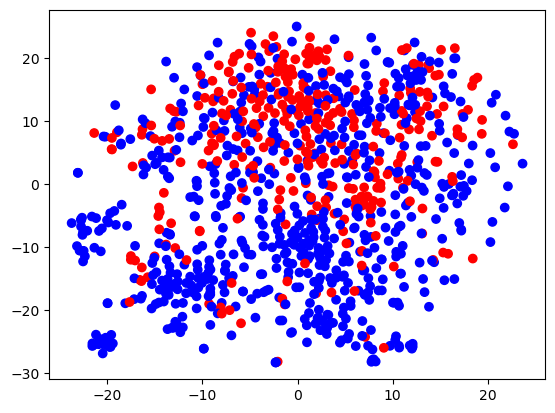

Words used for traning:
['suggest', 'parti', 'could', 'win', 'number', 'fewer', 'seat', 'parti', 'general', 'elect', 'america', 'flimsier', 'colossi', 'threaten', 'tend', 'follow', 'familiar', 'script', 'quarter', 'report', 'disappoint', 'media', 'begin', 'stir', 'question', 'financi', 'deal', 'come', 'light', 'ceo', 'emerg', 'bunker', 'announc', 'would', 'well', 'press', 'hell', 'break', 'loos', 'enron', 'lehman', 'brother', 'less', 'go', 'euro', 'danger', 'peopl', 'money', 'oper', 'dishonest', 'sold', 'european', 'singl', 'show', 'sign', 'sever', 'stress', 'lead', 'eu', 'offici', 'ken', 'lay', 'world', 'secur', 'forc', 'nigeria', 'arrest', 'student', 'christian', 'univers', 'central', 'state', 'convert', 'islam', 'christian', 'also', 'arrest', 'man', 'taken', 'local', 'church', 'reader', 'may', 'recal', 'scrapbook', 'redlight', 'camera', 'repres', 'perfect', 'case', 'technolog', 'design', 'creat', 'govern', 'revenu', 'rubric', 'yet', 'fail', 'level', 'across']

Words not used for tra

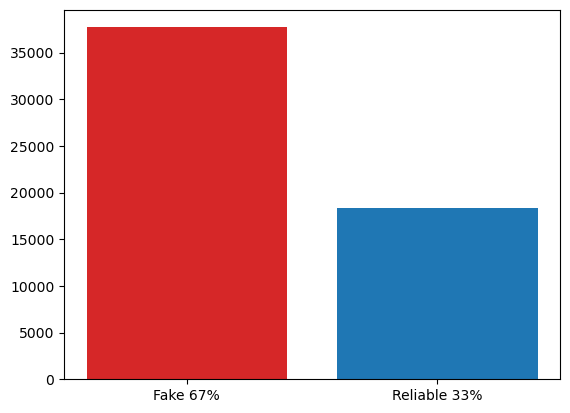

In [ ]:
##### -- functions -- #####
'''Plots the balance of the dataset'''
def balanceCheck():
    ones = 0
    zeros = 0
    for num in y_train:
        if num == 1:
            ones += 1
        elif num == 0:
            zeros += 1
    #Percentage
    total = ones + zeros
    percentOnes = round(ones/total * 100)
    percentZeros = round(zeros/total * 100)
    #Plot
    fig, ax = plt.subplots()
    labels = ['Fake ' + str(percentOnes) + '%', 'Reliable ' + str(percentZeros) + '%']
    size = [ones, zeros]
    bar_colors = ['tab:red', 'tab:blue']
    ax.bar(labels, size, label=labels, color=bar_colors)

'''Creates a scatter plot '''
def  scatterPlotOfdata(X, Y):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_vectors = tsne.fit_transform(X)
    scatter_colors = ListedColormap(['red', 'blue'])
    plt.scatter(reduced_vectors[:,0], reduced_vectors[:,1], c=Y, cmap=scatter_colors)
    plt.show()
    return reduced_vectors

##### --  Prints -- #####
print("Scatterplot")
scatterPlotOfdata(X_train[:1000], y_train[:1000])
print("Words used for traning:")
print(lstOfWordsInWv[:100])
print("\nWords not used for training")
print(lstOfWordsNotInWv[:100])

balanceCheck()


t-SNE: For dimensionality reduction
Scatterplot: There doesn't seem to be any clear patterns on where the position of the points are in correlation to wheter it's fake or reliable. 

word2vec-GoogleNews-vectors is from 2016, and doesn't contain words such as blockchain and bitcoin. (reference: https://github.com/mmihaltz/word2vec-GoogleNews-vectors)


##### Baseline model #####

In [ ]:
''' Grid search '''
def gridSearch():
    hyperparameters = {'penalty': ['l1', 'l2'], 
                       'class_weight': ['balanced', None], 
                       'solver': [‘lbfgs’, ‘liblinear’],
                       'C': [1000, 100, 10, 1.0, 0.1, 0.01]}
    grid_search = GridSearchCV(LogisticRegression(), hyperparameters, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print('Best hyperparameters:', grid_search.best_params_)
    print('Accuracy:', grid_search.best_score_)
#gridSearch()

For the baseline model we use logistic regression. With the hyperparameters we got from gridsearch. <br>
    - Works well with binary classification <br>
    - (C=100, class_weight=None, penalty='l1', solver='liblinear') 

Baseline models with content and w/o meta_description:

In [ ]:
'''Baseline model: Logistic regression with only content'''
modelC = sklearn.linear_model.LogisticRegression(C=100, class_weight=None, penalty='l1', solver='liblinear', max_iter=500)
modelC.fit(X_train, y_train) 
y_predC = modelC.predict(X_test) 

'''Baseline model: Logistic regression with both content and meta_description'''
modelM = sklearn.linear_model.LogisticRegression(C=100, class_weight=None, penalty='l1', solver='liblinear', max_iter=500)
modelM.fit(X_train_meta, y_train) 
y_predM = modelM.predict(X_test_meta)

Printing metrics

In [1]:
'''Logistic regression with only content'''
print("\nWithout meta_description")
print("Logistic MSE:",metrics.mean_squared_error(y_test, y_predC))
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_predC))
print("Logistic Regression Precision:",metrics.precision_score(y_test, y_predC))
print("Logistic Regression Recall:",metrics.recall_score(y_test, y_predC))

'''Logistic regression with both content and meta_description'''
print("\nWith meta_description")
print("Logistic MSE:",metrics.mean_squared_error(y_test, y_predM))
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_predM))
print("Logistic Regression Precision:",metrics.precision_score(y_test, y_predM))
print("Logistic Regression Recall:",metrics.recall_score(y_test, y_predM))




Without meta_description


NameError: name 'metrics' is not defined

##### Advanced model #####

In [54]:
##### Variables #####
df_lair = pd.read_csv('test.tsv', sep = '\t', header = None)

''' Converts statement into a list of word vectors '''
def LairToListX(input):
    df = (cleanContent(df_lair, 2))
    lst = vectorizeContent(df, 2)
    return lst

''' Converts label into binary list '''
def binaryLair(inp):
    lst = []
    for i in range(0, (inp.shape[0])):
        colElm = inp.at[i, 1]
        if colElm == 'true' or colElm == 'mostly-true':
            lst.append(0)
        else:
            lst.append(1)
    return lst

lairX_test = LairToListX(df_lair)
lairY_test = binaryLair(df_lair)